In [1]:
!pip install dmol-book

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.6 MB 2.0 MB/s 
     |████████████████████████████████| 43 kB 822 kB/s 
     |████████████████████████████████| 4.7 MB 47.2 MB/s 
     |████████████████████████████████| 250 kB 58.0 MB/s 
     |████████████████████████████████| 776.3 MB 10 kB/s 
     |████████████████████████████████| 47 kB 5.3 MB/s 
     |████████████████████████████████| 29.3 MB 1.5 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 
     |████████████████████████████████| 128 kB 65.4 MB/s 
     |████████████████████████████████| 352 kB 62.5 MB/s 
     |████████████████████████████████| 3.2 MB 41.5 MB/s 
     |████████████████████████████████| 117 kB 55.6 MB/s 
     |████████████████████████████████| 57 kB 6.4 MB/s 
     |████████████████████████████████| 154 kB 61.4 MB/s 
     |████████████████████████████████| 345 kB 62.7 MB/s 
     |████████████████████████████████| 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
import dmol
#import seaborn as sns
import rdkit, rdkit.Chem, rdkit.Chem.Draw
import tensorflow as tf
import urllib


from google.colab import drive 
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
dataset = pd.read_csv("gdrive/MyDrive/dataset/CSD_EES_DB.csv")
print(len(dataset))
dataset.head()


48182


,ID,doi,formula,NAts,SMILES,HOMO,LUMO,E(S1),f(S1),E(S2),f(S2),E(S3),f(S3),E(T1),E(T2),E(T3)
0,AACFAZ10,10.1107/S0108270183005156,C26 H22 Cl2 N2 O6,36.0,COC1=C(C(OC1=O)c1ccccc1Cl)C(C)=NN=C(C)C1=C(OC)...,-7.548438,-1.912144,3.1382,0.0027,3.8297,1.1448,4.5310,0.0000,2.2270,2.8977,3.0885
1,ABACIR,10.1107/S160053681103861X,C17 H21 N3 O4 S2,26.0,O=N(=O)c1ccccc1NCC1=CSC(=C1)S(=O)(=O)NC1CCCCC1,-7.675787,-1.725202,3.6720,0.0982,3.7456,0.0888,4.1316,0.0016,2.3255,2.8794,3.2735
2,ABADEO,10.1107/S1600536811039158,C30 H28 N6 O2,38.0,CN1N(c2ccccc2)C(=O)C(=C1C)N=Cc1ccccc1C=NC1=C(C...,-6.603659,-0.762191,3.9027,0.7900,4.0170,0.2765,4.1450,0.0455,2.6892,3.0039,3.5964
3,ABADUE,10.1107/S1600536811039110,C17 H17 N1 O4,22.0,COc1cc(OC)c(C=CC(=O)c2ccccn2)c(OC)c1,-6.790057,-0.969814,3.3127,0.0001,3.9203,0.7088,4.6824,0.0265,2.5848,2.9294,3.9060
4,ABAGAN,10.1107/S1600536811038177,C26 H17 O1 P1,28.0,O=P1(c2ccccc2)c2ccc3ccccc3c2c2c3ccccc3ccc12,-7.067613,-1.419890,3.6197,0.1814,4.2742,0.0073,4.4154,0.0007,2.5192,3.2095,3.8388


In [3]:
## Data Cleansing

print("Original dataset length: " + str(len(dataset)))
badboys = []   ## Certain SMILES values in the dataset are not understood by rdkit. They must be removed.
for i in reversed(range(len(dataset))): ## go backwards through list so indexes don't get messed up during the iteration
  try:
    m = rdkit.Chem.MolFromSmiles(dataset.SMILES[i])
    m = rdkit.Chem.AddHs(m)
    #print(i)
  except: 
    badboys.append(i)
#print("there are " + str(len(badboys)) + " evil values:")
#print( badboys)


for i in range(len(badboys)):
  n = badboys[i]
  dataset = dataset.drop([dataset.index[n]])  ## remove bad values from dataset
dataset = dataset.reset_index(drop=True)
#print("new dataset length = " + str(len(dataset)))

Imolecules = []          ## Certain molecules in the dataset contain atoms which do not appear often. For simplicity, they should be removed.#
Semolecules = []
Asmolecules = []
normalmolecules = []
for i in reversed(range(len(dataset))):
  m = rdkit.Chem.MolFromSmiles(dataset.SMILES[i])
  for atom in m.GetAtoms():
    if atom.GetSymbol() == "I":
      Imolecules.append(dataset.index[i])
    elif atom.GetSymbol() == "Se":
      Semolecules.append(dataset.index[i])
    elif atom.GetSymbol() == "As":
      Asmolecules.append(dataset.index[i])
    else:
      normalmolecules.append(dataset.index[i])

allbadmolecules = Asmolecules + Semolecules + Imolecules
allbadmolecules.sort(reverse=True)

nodupe = []
[nodupe.append(x) for x in allbadmolecules if x not in nodupe]
#print(nodupe) ## these are the indexes of all molecules in the dataset that contain uncommon atoms.
#print(len(nodupe))

for i in range(len(nodupe)):
  n = nodupe[i]
  dataset = dataset.drop([dataset.index[n]])  ## remove bad values from dataset
dataset = dataset.reset_index(drop=True)
print("New dataset length: " + str(len(dataset)))

Original dataset length: 48182
New dataset length: 46206


In [4]:
## Defining functions for the network

np.random.seed(0)
def gen_smiles2graph(sml):   ## This function is taken from dmol book 
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, 54))
    for i in m.GetAtoms():
        nodes[i.GetIdx(), i.GetAtomicNum()] = 1

    adj = np.zeros((N, N))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v] = 1
        adj[v, u] = 1
    adj += np.eye(N)
    return nodes, adj


## GCNLayer and GR layer are taken from dmol book
class GCNLayer(tf.keras.layers.Layer):  ## Graph Convolution Network definition
    def __init__(self, activation=None, **kwargs):
        super(GCNLayer, self).__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # create trainable weights
        node_shape, adj_shape = input_shape
        self.w = self.add_weight(shape=(node_shape[2], node_shape[2]), name="w")

    def call(self, inputs):
        # split input into nodes, adj
        nodes, adj = inputs
        # compute degree
        degree = tf.reduce_sum(adj, axis=-1)
        # GCN equation
        new_nodes = tf.einsum("bi,bij,bjk,kl->bil", 1 / degree, adj, nodes, self.w)
        out = self.activation(new_nodes)
        return out, adj

class GRLayer(tf.keras.layers.Layer): ##  Layer than computes mean over node features
    def __init__(self, name="GRLayer", **kwargs):
        super(GRLayer, self).__init__(name=name, **kwargs)

    def call(self, inputs):
        nodes, adj = inputs
        reduction = tf.reduce_mean(nodes, axis=1)
        return reduction

In [28]:
## Preparing data
meanhomo = float(dataset[['HOMO']].mean())
def gen():   ## generate graphs and labels
    for i in range(len(dataset)):
        graph = gen_smiles2graph(dataset.SMILES[i])
        homo = jnp.where(dataset.HOMO.values[i] > meanhomo, x=1, y=0)
        yield graph, homo

data = tf.data.Dataset.from_generator(gen, output_types=((tf.float32, tf.float32), tf.float32),
    output_shapes=((tf.TensorShape([None, 54]), tf.TensorShape([None, None])), tf.TensorShape([]), ),)

data.shuffle(30000, seed=1)
test_data = data.take(600).shuffle(200, seed=1)
val_data = data.skip(600).take(600).shuffle(200, seed=1)
train_data = data.skip(1200).shuffle(200, seed=1)


In [29]:
##Model

ninput = tf.keras.Input((None,54,))
ainput = tf.keras.Input((None,None,))

x = GCNLayer("relu")([ninput, ainput])
x = GCNLayer("relu")(x)
x = GCNLayer("relu")(x)
x = GCNLayer("relu")(x)
# reduce to graph features
x = GRLayer()(x)
x = tf.keras.layers.Dense(96, activation = "relu")(x)
x = tf.keras.layers.Dense(64, activation = "relu")(x)
x = tf.keras.layers.Dense(32, activation = "relu")(x)
#x = tf.keras.layers.Dropout(0.18)(x)
x = tf.keras.layers.Dense(12, activation = "sigmoid")(x)
x = tf.keras.layers.Dense(2, activation = "softmax")(x)
model = tf.keras.Model(inputs=(ninput, ainput), outputs=x)
model.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, 54)]   0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None, None)  0           []                               
                                ]                                                                 
                                                                                                  
 gcn_layer_8 (GCNLayer)         ((None, None, 54),   2916        ['input_5[0][0]',                
                                 (None, None, None)               'input_6[0][0]']                
                                )                                                           

In [30]:
model.compile("adam", loss="mean_squared_error")
result = model.fit(train_data.batch(1), validation_data=val_data.batch(1), epochs=3)

Epoch 1/3
45006/45006 [==============================] - 309s 7ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/3
45006/45006 [==============================] - 316s 7ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/3
45006/45006 [==============================] - 332s 7ms/step - loss: 0.2500 - val_loss: 0.2500


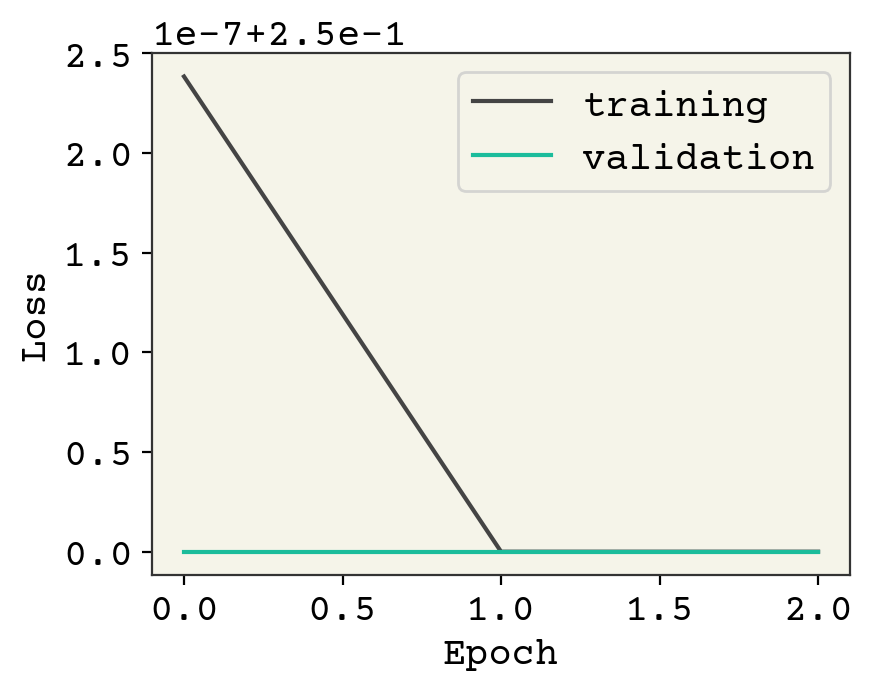

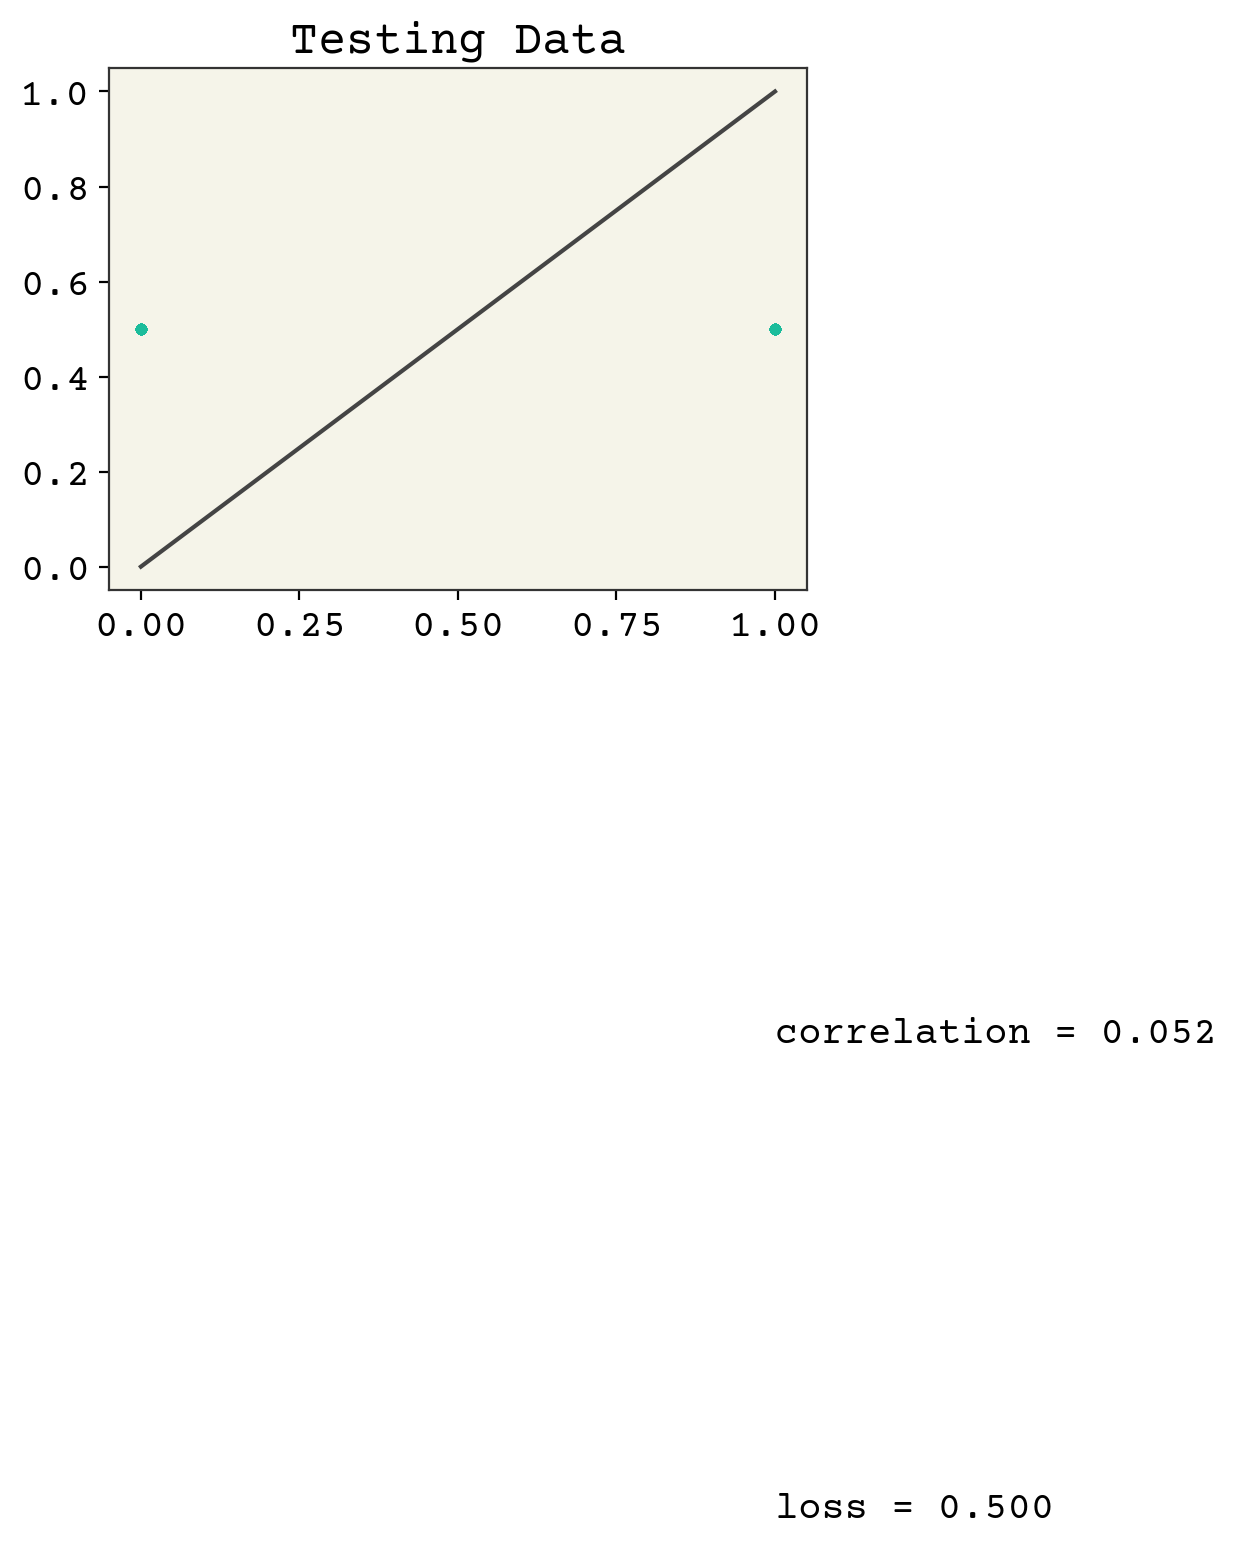

In [31]:
plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
yhat = model.predict(test_data.batch(1), verbose=0)[:, 0]
test_y = [y for x, y in test_data]
plt.figure()
plt.plot(test_y, test_y, "-")
plt.plot(test_y, yhat, ".")
plt.text(
    min(test_y) + 1,
    max(test_y) - 2,
    f"correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}",
)
plt.text(
    min(test_y) + 1,
    max(test_y) - 3,
    f"loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}",
)
plt.title("Testing Data")
plt.show()

In [ ]:
model.predict(gen_smiles2graph(dataset.SMILES[1]))

ValueError: ignored